# Brent oil prediction using SVM
### Pete Pritchard 

In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [64]:
from pandas_datareader import DataReader
from datetime import datetime

# 1: Data import and clean

In [65]:
start = datetime(2007, 7, 29)
end = datetime(2022, 7, 29)
sym = ["SPY","BZ=F"]

data = DataReader(sym, "yahoo", start, end)
data.head()

Attributes   Adj Close                  Close                   High  \
Symbols            SPY       BZ=F         SPY       BZ=F         SPY   
Date                                                                   
2007-07-30  109.637550  75.739998  147.380005  75.739998  147.809998   
2007-07-31  108.402664  77.050003  145.720001  77.050003  149.460007   
2007-08-01  108.930779  75.349998  146.429993  75.349998  147.009995   
2007-08-02  109.801178  75.760002  147.600006  75.760002  147.759995   
2007-08-03  106.974312  74.750000  143.800003  74.750000  147.580002   

Attributes                    Low                   Open             \
Symbols          BZ=F         SPY       BZ=F         SPY       BZ=F   
Date                                                                  
2007-07-30  76.529999  145.289993  75.440002  145.929993  75.849998   
2007-07-31  77.169998  145.039993  75.669998  148.330002  75.699997   
2007-08-01  77.059998  143.949997  74.860001  145.179993  77.000000   
2007-08-02  76.209999  145.259995  74.269997  146.759995  75.220001   
2007-08-03  76.000000  143.199997  74.529999  147.279999  75.389999   

Attributes       Volume          
Symbols             SPY    BZ=F  
Date                             
2007-07-30  283017500.0  2575.0  
2007-07-31  316976700.0  3513.0  
2007-08-01  467670000.0  3930.0  
2007-08-02  294758400.0  6180.0  
2007-08-03  359398200.0  4387.0

In [66]:
df = data[["Close","High","Low","Open","Volume"]]

In [67]:
df.columns = ["Brent Close", "SPY Close", "Brent High", "SPY High", "Brent Low", 
              "SPY Low","Brent Open", "SPY Open", "Brent Volume", "SPY Volume"]

In [68]:
# Calculating the monthly average 

df = df.resample('1M').mean().copy()
df.head()

,Brent Close,SPY Close,Brent High,SPY High,Brent Low,SPY Low,Brent Open,SPY Open,Brent Volume,SPY Volume
Date,,,,,,,,,,
2007-07-31,146.550003,76.395000,148.635002,76.849998,145.164993,75.555000,147.129997,75.774998,2.999971e+08,3044.000000
2007-08-31,145.645652,71.258696,147.026522,72.037826,144.069999,70.489130,145.690868,71.391306,2.693878e+08,4436.173913
2007-09-30,149.954738,77.135263,150.572105,77.599473,148.940527,76.128948,149.709474,76.680526,1.561584e+08,3265.368421
2007-10-31,153.871303,82.456957,154.649131,82.999131,152.781304,81.205652,153.886087,81.946521,1.673943e+08,3216.260870
2007-11-30,146.478095,92.060953,147.920952,93.143333,145.229525,91.029524,146.837620,92.288572,2.606052e+08,1937.190476


In [69]:
# Before I go any further - check for NaNs in the dataframe

df.isnull().values.any()

False

The oil prediction indicator variables from Christine Baumeister

In [70]:
# Return column 
df["Return"] = df["Brent Close"].pct_change()
# H - L column 
df["H-L"] = df["Brent High"] - df["Brent Low"]
# Direction column - this is our label variable
df["Dir"] = (df["Return"] >= 0).astype(int) ### 1 = Up, 0 = Down

In [71]:
df.head()

,Brent Close,SPY Close,Brent High,SPY High,Brent Low,SPY Low,Brent Open,SPY Open,Brent Volume,SPY Volume,Return,H-L,Dir
Date,,,,,,,,,,,,,
2007-07-31,146.550003,76.395000,148.635002,76.849998,145.164993,75.555000,147.129997,75.774998,2.999971e+08,3044.000000,NaN,3.470009,0
2007-08-31,145.645652,71.258696,147.026522,72.037826,144.069999,70.489130,145.690868,71.391306,2.693878e+08,4436.173913,-0.006171,2.956523,0
2007-09-30,149.954738,77.135263,150.572105,77.599473,148.940527,76.128948,149.709474,76.680526,1.561584e+08,3265.368421,0.029586,1.631578,1
2007-10-31,153.871303,82.456957,154.649131,82.999131,152.781304,81.205652,153.886087,81.946521,1.673943e+08,3216.260870,0.026118,1.867826,1
2007-11-30,146.478095,92.060953,147.920952,93.143333,145.229525,91.029524,146.837620,92.288572,2.606052e+08,1937.190476,-0.048048,2.691427,0


In [72]:
# Importing Christiane Baumiester macroeconomic data.

df2 = pd.read_excel('/Users/petepritchard/Documents/Python/G7/data/baumeister_data.xlsx', index_col="Date")
df = df.join(df2)
df.head()

,Brent Close,SPY Close,Brent High,SPY High,Brent Low,SPY Low,Brent Open,SPY Open,Brent Volume,SPY Volume,Return,H-L,Dir,Industrial Production,GEC Index,Supply Shocks,Economic Demand,Consumption Demand,Inventory Demand
Date,,,,,,,,,,,,,,,,,,,
2007-07-31,146.550003,76.395000,148.635002,76.849998,145.164993,75.555000,147.129997,75.774998,2.999971e+08,3044.000000,NaN,3.470009,0,111.9780,0.258167,0.314248,0.085265,4.125458,-0.862854
2007-08-31,145.645652,71.258696,147.026522,72.037826,144.069999,70.489130,145.690868,71.391306,2.693878e+08,4436.173913,-0.006171,2.956523,0,112.4597,-0.134781,-0.701338,-0.118095,-2.180688,-1.224690
2007-09-30,149.954738,77.135263,150.572105,77.599473,148.940527,76.128948,149.709474,76.680526,1.561584e+08,3265.368421,0.029586,1.631578,1,112.5314,-0.101171,-0.848879,-0.023169,5.226190,-0.350879
2007-10-31,153.871303,82.456957,154.649131,82.999131,152.781304,81.205652,153.886087,81.946521,1.673943e+08,3216.260870,0.026118,1.867826,1,113.2724,-0.040119,0.079020,0.160989,2.890667,-0.365979
2007-11-30,146.478095,92.060953,147.920952,93.143333,145.229525,91.029524,146.837620,92.288572,2.606052e+08,1937.190476,-0.048048,2.691427,0,113.7429,-0.376144,-1.564182,0.048327,2.856990,-0.681337


In [86]:
df["Dir IP"] = (df["Industrial Production"].pct_change() >= 0).astype(int) ### 1 = Up, 0 = Down
df["Dir SPY"] = (df["SPY Close"].pct_change() >= 0).astype(int) ### 1 = Up, 0 = Down

In [73]:
df = df.dropna()

In [87]:
X = df[["Dir SPY","H-L","Dir IP","GEC Index","Supply Shocks","Economic Demand",
      "Consumption Demand", "Inventory Demand"]].copy()

X.head()

,Dir SPY,H-L,Dir IP,GEC Index,Supply Shocks,Economic Demand,Consumption Demand,Inventory Demand
Date,,,,,,,,
2007-08-31,0,2.956523,0,-0.134781,-0.701338,-0.118095,-2.180688,-1.224690
2007-09-30,1,1.631578,1,-0.101171,-0.848879,-0.023169,5.226190,-0.350879
2007-10-31,1,1.867826,1,-0.040119,0.079020,0.160989,2.890667,-0.365979
2007-11-30,1,2.691427,1,-0.376144,-1.564182,0.048327,2.856990,-0.681337
2007-12-31,0,1.954999,1,-0.441074,0.232696,-0.116146,-2.488767,0.557617


In [88]:
y = df['Dir'].copy()

y.head()

Date
2007-08-31    0
2007-09-30    1
2007-10-31    1
2007-11-30    0
2007-12-31    1
Freq: M, Name: Dir, dtype: int64

In [89]:
split_percentage = 0.8
split = int(split_percentage*len(df))
  
# Train data set
X_train = X[:split]
y_train = y[:split]
  
# Test data set
X_test = X[split:]
y_test = y[split:]

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# 2: Preliminary Support Vector Machine

In [90]:
clf_svm = SVC()
clf_svm.fit(X_train_scaled, y_train)

SVC()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


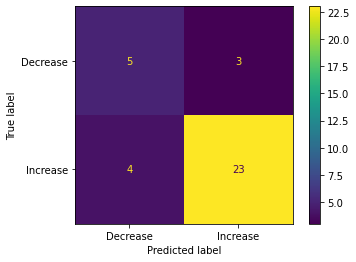

In [91]:
plot_confusion_matrix(clf_svm, 
                     X_test_scaled, 
                     y_test,
                     values_format="d",
                     display_labels=["Decrease", "Increase"])

In the confusion matrix, we can see that of the __8__ months when the Brent Oil price decreased, __5(62.5%)__ were correctly predicted. And of the __27__ months when the price increased, __23(85.2%)__ were correctly predicted. Not awful, but now I'll try to imporve the model use __cross validation__ to optimize the parameters.

# 3: Optimize Parameters with Cross Validation and GridSearchCV()

In [92]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # Note: Values for C must be > 0 
     'gamma': ['scale', 1, 0.1, 0.001, 0.0001],
     'kernel': ['rbf']},
]

## Note: We are including C=1 and gamma="scale"
## as possible choices since they are the default values. 

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0 # Note: If you want to see what Grid Search is doing set verbose=2
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


# 4: Building final Support Vector Machine 

In [93]:
clf_svm = SVC(C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


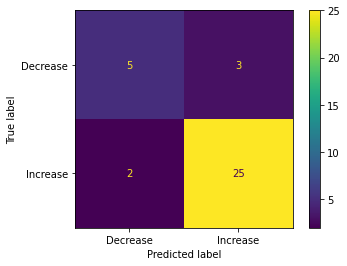

In [94]:
plot_confusion_matrix(clf_svm, 
                     X_test_scaled, 
                     y_test,
                     values_format="d",
                     display_labels=["Decrease", "Increase"])

<function matplotlib.pyplot.show(close=None, block=None)>

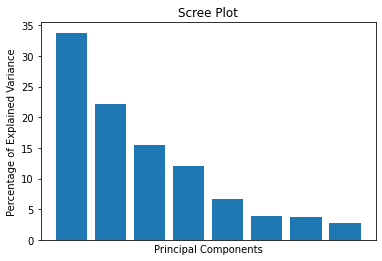

In [95]:
pca = PCA() # Note: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=False,       # ticks along the bottom edge are off
    top=False,          # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show